# lasso-100-restricted

# Direct Regression - Bayesian Version

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

from scipy.stats import norm, mstats
from cinspect.estimators import BayesianRidgeStat
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, DotProduct
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import r2_score

from reed import drop_missing_treatment_or_outcome, Model, transform_outcome
from direct_regression import seperate_and_transform_data, print_unconditional_effects


torch.set_default_tensor_type(torch.DoubleTensor) # set the default to float64
%matplotlib inline

## Analysis Parameters

In [2]:
log_outcome=True
standardize_outcome=True
exclude_patterns = [
    '^reduhl$', '^rehllt$', '^redudl$', '^redufl$', '^redllt$', '^refllt$',
    '^rlwage$', '^mh$', '^mhbm$', '^wkhr$', '^y_', '^p_rcom','^p_rdf','^p_cotrl',
    '^xwaveid$','p_rcom18','^aedcq', '^abnfsty','^aedcqfpt','^aedqstdy'
]
data_load_func = lambda filepath: pd.read_csv(filepath, index_col='xwaveid')

#configuration_name = 'default'
outcome = 'y_wsce'
treatment = 'redufl'
test = False
data_file = "data/all_lasso_selected_100.csv"
xval_gp = False
laplace_prior = False 

In [3]:
# Parameters
configuration_name = "lasso-100-restricted"
outcome = "y_wsce"
treatment = "redufl"
test = False
data_file = "data/all_lasso_selected_100_restricted.csv"
release = "restricted"
laplace_prior = False
xval_gp = True


## Load the data

Dropped 284 rows missing treatment or outcome.


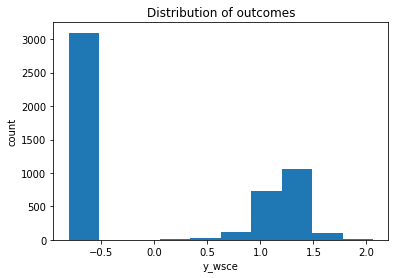

In [4]:
data = data_load_func(data_file)
drop_missing_treatment_or_outcome(data, treatment, outcome)
data[outcome] = transform_outcome(data[outcome],log_outcome, standardize_outcome)

    
plt.hist(data[outcome])
plt.xlabel(outcome)
plt.ylabel("count")
plt.title("Distribution of outcomes");

## Prepare data for modeling

- split into treated/control
- impute missing values and scale
- separate features from outcomes&treatments



In [5]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)
print("Control data dimensions: ", X0.shape)
print("Treated data dimensions:", X1.shape)

Control data dimensions:  (3789, 91)
Treated data dimensions: (1368, 91)


## Compute unconditional/unadjusted estimate of treatment effect

In [6]:
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:27%
Average outcome under Control:-0.14±0.02
Average outcome under Treatment:0.37±0.03
Unadjusted treatment estimate 0.51


## Statsmodels

### OLS

In [7]:
Xt = np.hstack((t[:, np.newaxis], X))
Xt = pd.DataFrame(data=Xt, columns=["treatment"] + features)
ols = sm.OLS(y, sm.add_constant(Xt))
res = ols.fit()
ate_ols = res.params.loc["treatment"]
ci_ols = res.conf_int().loc["treatment"]
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     39.92
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:33:59   Log-Likelihood:                -5911.1
No. Observations:                5157   AIC:                         1.201e+04
Df Residuals:                    5064   BIC:                         1.262e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0382      0.013     -2.996      0.0

## Scikit learn Bayesian Estimators

### Bayesian Ridge

Coefficient statistics

In [8]:
blr = BayesianRidgeStat()
blr.fit(Xt, y)

score = blr.score(Xt, y)

# Coefficient statistics
stats = blr.model_statistics()
ate_blr, se_blr = stats.beta[0], stats.std_err[0]
ci_blr = norm.interval(loc=ate_blr, scale=se_blr, alpha=0.95)

print("Bayesian Ridge simple model - coefficient stats:")
print(f"  R-squared = {score:.4f}")
print(f"  ATE: {ate_blr:.4f} ({se_blr:.4f})")
print(f"  t: {stats.t_stat[0]:.4f}")
print(f"  p-value: {stats.p_value[0]:.4f}")
print(f"  CI (0.025, 0.975): [{ci_blr[0]:.4f}, {ci_blr[1]:.4f}]")

Bayesian Ridge simple model - coefficient stats:
  R-squared = 0.4195
  ATE: 0.1102 (0.0224)
  t: 4.9268
  p-value: 0.0000
  CI (0.025, 0.975): [0.0664, 0.1541]


ATE sampling with counterfactual models

In [9]:
# ATE sampling
samples = 100
w_samples = np.random.multivariate_normal(mean=blr.coef_, cov=blr.sigma_, size=samples).T

n = len(X)
Xt0 = pd.DataFrame(data=np.hstack((np.zeros((n, 1)), X)), columns=["treatment"] + features)
Xt1 = pd.DataFrame(data=np.hstack((np.ones((n, 1)), X)), columns=["treatment"] + features)

ate_blr_samples = np.mean(Xt1 @ w_samples, axis=0) - np.mean(Xt0 @ w_samples, axis=0)
ate_blr = ate_blr_samples.mean()
se_blr = np.std(ate_blr_samples, ddof=1)
ci_blr = norm.interval(loc=ate_blr, scale=se_blr, alpha=0.95)

print("Bayesian Ridge simple model - counterfactual sampling:")
print(f"  R-squared = {score:.4f}")
print(f"  ATE: {ate_blr:.4f} ({se_blr:.4f})")
print(f"  CI (0.025, 0.975): [{ci_blr[0]:.4f}, {ci_blr[1]:.4f}]")

Bayesian Ridge simple model - counterfactual sampling:
  R-squared = 0.4195
  ATE: 0.1102 (0.0253)
  CI (0.025, 0.975): [0.0607, 0.1598]


### Gaussian Process

In [10]:
kernel = WhiteKernel() + Matern(nu=1.5)
gpr = GaussianProcessRegressor(kernel=kernel)

# This takes a while for 5000 samples... (5 mins or so)
gpr.fit(Xt, y)
score = gpr.score(Xt, y)

In [11]:
# ATE sampling   
f0, K0 = gpr.predict(Xt0, return_cov=True)
f1, K1 = gpr.predict(Xt1, return_cov=True)

y_0_samples = np.random.multivariate_normal(mean=f0, cov=K0, size=samples)
y_1_samples = np.random.multivariate_normal(mean=f1, cov=K1, size=samples)
ate_gp_samples = (y_1_samples - y_0_samples).mean(axis=1)

ate_gp = ate_gp_samples.mean()
se_gp = np.std(ate_gp_samples, ddof=1)
ci_gp = norm.interval(loc=ate_gp, scale=se_gp, alpha=0.95)

print(f"Gaussian Process {gpr.kernel_}:")
print(f"  R-squared = {score:.4f}")
print(f"  ATE: {ate_gp:.4f} ({se_gp:.4f})")
print(f"  CI (0.025, 0.975): [{ci_gp[0]:.4f}, {ci_gp[1]:.4f}]")

Gaussian Process WhiteKernel(noise_level=0.473) + Matern(length_scale=18.1, nu=1.5):
  R-squared = 0.6074
  ATE: 0.1099 (0.0242)
  CI (0.025, 0.975): [0.0624, 0.1573]


Check if GP is overfitting

In [12]:
if xval_gp:
    cv_scores = cross_validate(gpr, Xt, y,
                               cv=KFold(n_splits=5, shuffle=True),
                               return_train_score=True)
    pd.DataFrame(cv_scores).describe()

## Hierarchical Bayesian Linear Model

This model takes the following form and prior settings,

$$
\begin{align}
    \{\lambda_0, \lambda_t, \lambda_x, \lambda_{tx}\} &\sim \textrm{Gamma}(1, 1) \\
    \sigma^2 &\sim \textrm{Gamma}(1, 1) \\
    w_0 &\sim \mathcal{N}(0, \lambda_0) \\
    w_t &\sim \mathcal{N}(0, \lambda_t) \\
    \mathbf{w}_x &\sim \mathcal{N}(0, \lambda_x \mathbf{I}_d) \\
    \mathbf{w}_{tx} &\sim \mathcal{N}(0, \lambda_{tx} \mathbf{I}_d) \\
    y_i &\sim \mathcal{N}(\mu(\mathbf{x}_i, t_i), \sigma^2) \\
    \mu(\mathbf{x}_i, t_i) &= w_0 + w_t t_i + \mathbf{w}_x^\top\mathbf{x}_i + t_i\mathbf{w}_{tx}^\top\mathbf{x}_i
\end{align}
$$

### Set up the model

In [13]:
def predict(w_0, w_t, w_x, w_tx, x, t):
    f = w_0 + w_t * t + x.matmul(w_x.T) + t * x.matmul(w_tx.T)
    return f


def model_treatment_intersection(x, t, y):
    # Hyper-Priors
    lambda_prior = dist.Gamma(1., 1.)
    sigma_prior = dist.Gamma(1., 1.)
    
    # Priors
    n, d = x.shape
    weight_prior = dist.Laplace if laplace_prior else dist.Normal
    p_w0 = weight_prior(0, pyro.sample("l_0", lambda_prior))
    p_wt = weight_prior(0, pyro.sample("l_t", lambda_prior))
    p_wx = weight_prior(torch.zeros(d), pyro.sample("l_x", lambda_prior) * torch.ones(d))
    p_twx = weight_prior(torch.zeros(d), pyro.sample("l_tx", lambda_prior) * torch.ones(d))
    
    # Model weights
    w_0 = pyro.sample("intercept", p_w0)
    w_t = pyro.sample("treatment", p_wt)
    w_x = pyro.sample("confounders", p_wx)
    w_tx = pyro.sample("intersection", p_twx)
    
    # Likelihood
    f = predict(w_0, w_t, w_x, w_tx, x, t)
    sigma = pyro.sample("variance", sigma_prior)
    
    with pyro.plate("data", n):
        likelihood = dist.Normal(f, sigma)
        y = pyro.sample("likelihood", likelihood, obs=y)

### Run MCMC inference to compute the posteriors

In [14]:
samples = 500
warm_up = 200

X_torch = torch.tensor(X)
t_torch = torch.tensor(t)
y_torch = torch.tensor(y)


# Initialize No U-Turn Sampler
nuts_kernel = NUTS(model_treatment_intersection, max_tree_depth=7)
model_mcmc = MCMC(nuts_kernel, num_samples=samples, warmup_steps=warm_up)

# Run the sampler
model_mcmc.run(X_torch, t_torch, y_torch)

Warmup:   0%|                                                                     | 0/700 [00:00, ?it/s]

Warmup:   0%|                            | 1/700 [00:00,  7.05it/s, step size=5.62e-02, acc. prob=1.000]

Warmup:   1%|▏                           | 4/700 [00:00,  8.51it/s, step size=2.21e-02, acc. prob=0.750]

Warmup:   1%|▏                           | 6/700 [00:00,  6.78it/s, step size=3.32e-03, acc. prob=0.666]

Warmup:   1%|▎                           | 7/700 [00:01,  4.92it/s, step size=4.97e-03, acc. prob=0.705]

Warmup:   2%|▍                          | 11/700 [00:01,  9.12it/s, step size=7.35e-03, acc. prob=0.752]

Warmup:   2%|▌                          | 13/700 [00:01,  9.95it/s, step size=1.13e-03, acc. prob=0.713]

Warmup:   2%|▌                          | 15/700 [00:02,  4.20it/s, step size=4.07e-03, acc. prob=0.751]

Warmup:   2%|▌                          | 16/700 [00:02,  4.29it/s, step size=7.56e-03, acc. prob=0.767]

Warmup:   3%|▋                          | 18/700 [00:03,  4.92it/s, step size=3.28e-03, acc. prob=0.755]

Warmup:   3%|▋                          | 19/700 [00:03,  4.28it/s, step size=5.73e-03, acc. prob=0.766]

Warmup:   3%|▊                          | 20/700 [00:03,  4.65it/s, step size=2.98e-03, acc. prob=0.757]

Warmup:   3%|▊                          | 21/700 [00:04,  4.16it/s, step size=3.61e-03, acc. prob=0.762]

Warmup:   3%|▊                          | 22/700 [00:04,  4.56it/s, step size=4.53e-03, acc. prob=0.767]

Warmup:   3%|▉                          | 23/700 [00:04,  5.05it/s, step size=4.17e-03, acc. prob=0.767]

Warmup:   3%|▉                          | 24/700 [00:04,  5.26it/s, step size=7.56e-03, acc. prob=0.776]

Warmup:   4%|█                          | 26/700 [00:05,  3.78it/s, step size=2.35e-03, acc. prob=0.762]

Warmup:   4%|█                          | 27/700 [00:05,  3.71it/s, step size=2.95e-03, acc. prob=0.766]

Warmup:   4%|█                          | 28/700 [00:05,  3.68it/s, step size=4.03e-03, acc. prob=0.771]

Warmup:   4%|█                          | 29/700 [00:05,  4.26it/s, step size=6.31e-03, acc. prob=0.777]

Warmup:   4%|█▏                         | 30/700 [00:06,  4.84it/s, step size=4.79e-03, acc. prob=0.774]

Warmup:   4%|█▏                         | 31/700 [00:06,  5.31it/s, step size=4.00e-03, acc. prob=0.773]

Warmup:   5%|█▏                         | 32/700 [00:06,  5.75it/s, step size=5.05e-03, acc. prob=0.776]

Warmup:   5%|█▎                         | 33/700 [00:06,  6.11it/s, step size=7.41e-03, acc. prob=0.781]

Warmup:   5%|█▎                         | 35/700 [00:06,  5.76it/s, step size=3.57e-03, acc. prob=0.774]

Warmup:   5%|█▍                         | 36/700 [00:06,  6.12it/s, step size=4.32e-03, acc. prob=0.777]

Warmup:   5%|█▍                         | 37/700 [00:07,  6.45it/s, step size=6.67e-03, acc. prob=0.782]

Warmup:   6%|█▌                         | 39/700 [00:07,  6.23it/s, step size=2.79e-03, acc. prob=0.773]

Warmup:   6%|█▌                         | 40/700 [00:07,  6.46it/s, step size=4.66e-03, acc. prob=0.779]

Warmup:   6%|█▌                         | 42/700 [00:07,  8.04it/s, step size=3.39e-03, acc. prob=0.777]

Warmup:   6%|█▋                         | 43/700 [00:07,  7.29it/s, step size=5.19e-03, acc. prob=0.781]

Warmup:   6%|█▋                         | 44/700 [00:08,  7.67it/s, step size=4.22e-03, acc. prob=0.779]

Warmup:   6%|█▋                         | 45/700 [00:08,  6.63it/s, step size=6.25e-03, acc. prob=0.783]

Warmup:   7%|█▊                         | 47/700 [00:08,  5.61it/s, step size=2.77e-03, acc. prob=0.777]

Warmup:   7%|█▊                         | 48/700 [00:08,  5.84it/s, step size=4.38e-03, acc. prob=0.781]

Warmup:   7%|█▉                         | 50/700 [00:09,  6.38it/s, step size=4.39e-03, acc. prob=0.781]

Warmup:   7%|██                         | 52/700 [00:09,  7.66it/s, step size=7.48e-03, acc. prob=0.786]

Warmup:   8%|██                         | 54/700 [00:09,  7.83it/s, step size=5.58e-03, acc. prob=0.784]

Warmup:   8%|██▏                        | 56/700 [00:09,  8.91it/s, step size=4.51e-03, acc. prob=0.783]

Warmup:   8%|██▏                        | 57/700 [00:09,  8.40it/s, step size=2.67e-03, acc. prob=0.779]

Warmup:   8%|██▏                        | 58/700 [00:09,  7.88it/s, step size=4.11e-03, acc. prob=0.783]

Warmup:   9%|██▎                        | 60/700 [00:10,  9.02it/s, step size=4.46e-03, acc. prob=0.784]

Warmup:   9%|██▎                        | 61/700 [00:10,  6.21it/s, step size=3.85e-03, acc. prob=0.783]

Warmup:   9%|██▍                        | 62/700 [00:10,  5.95it/s, step size=5.00e-03, acc. prob=0.785]

Warmup:   9%|██▍                        | 64/700 [00:10,  7.66it/s, step size=2.47e-03, acc. prob=0.780]

Warmup:   9%|██▌                        | 65/700 [00:10,  7.30it/s, step size=3.75e-03, acc. prob=0.783]

Warmup:   9%|██▌                        | 66/700 [00:11,  7.26it/s, step size=4.82e-03, acc. prob=0.785]

Warmup:  10%|██▌                        | 68/700 [00:11,  6.06it/s, step size=2.47e-03, acc. prob=0.781]

Warmup:  10%|██▋                        | 69/700 [00:11,  5.76it/s, step size=3.81e-03, acc. prob=0.784]

Warmup:  10%|██▋                        | 70/700 [00:11,  5.82it/s, step size=5.53e-03, acc. prob=0.787]

Warmup:  10%|██▊                        | 72/700 [00:12,  6.37it/s, step size=4.18e-03, acc. prob=0.785]

Warmup:  10%|██▊                        | 73/700 [00:12,  6.22it/s, step size=5.20e-03, acc. prob=0.787]

Warmup:  11%|██▉                        | 75/700 [00:12,  5.53it/s, step size=3.36e-03, acc. prob=0.784]

Warmup:  11%|██▉                        | 76/700 [00:12,  5.73it/s, step size=4.56e-03, acc. prob=0.786]

Warmup:  11%|███                        | 78/700 [00:13,  7.41it/s, step size=2.45e-03, acc. prob=0.782]

Warmup:  11%|███                        | 79/700 [00:13,  7.33it/s, step size=3.70e-03, acc. prob=0.785]

Warmup:  11%|███                        | 80/700 [00:13,  7.32it/s, step size=2.67e-03, acc. prob=0.783]

Warmup:  12%|███                        | 81/700 [00:13,  7.27it/s, step size=3.98e-03, acc. prob=0.786]

Warmup:  12%|███▏                       | 83/700 [00:13,  9.26it/s, step size=2.45e-03, acc. prob=0.783]

Warmup:  12%|███▏                       | 84/700 [00:13,  8.57it/s, step size=3.32e-03, acc. prob=0.785]

Warmup:  12%|███▎                       | 85/700 [00:13,  7.90it/s, step size=4.54e-03, acc. prob=0.787]

Warmup:  12%|███▎                       | 86/700 [00:14,  7.36it/s, step size=3.09e-03, acc. prob=0.785]

Warmup:  12%|███▎                       | 87/700 [00:14,  6.97it/s, step size=4.49e-03, acc. prob=0.787]

Warmup:  13%|███▍                       | 89/700 [00:14,  7.85it/s, step size=5.56e-03, acc. prob=0.789]

Warmup:  13%|███▌                       | 91/700 [00:14,  9.64it/s, step size=7.13e-03, acc. prob=0.790]

Warmup:  13%|███▋                       | 94/700 [00:14, 11.15it/s, step size=3.01e-03, acc. prob=0.785]

Warmup:  14%|███▋                       | 96/700 [00:15,  9.14it/s, step size=2.74e-03, acc. prob=0.785]

Warmup:  14%|███▋                       | 97/700 [00:15,  8.69it/s, step size=4.00e-03, acc. prob=0.787]

Warmup:  14%|███▊                       | 99/700 [00:15,  7.74it/s, step size=4.09e-01, acc. prob=0.786]

Warmup:  15%|███▊                      | 102/700 [00:15,  9.06it/s, step size=9.81e-02, acc. prob=0.773]

Warmup:  15%|███▊                      | 103/700 [00:15,  8.47it/s, step size=1.09e-01, acc. prob=0.774]

Warmup:  15%|███▊                      | 104/700 [00:16,  7.49it/s, step size=1.70e-01, acc. prob=0.777]

Warmup:  15%|███▉                      | 106/700 [00:16,  9.41it/s, step size=5.39e-02, acc. prob=0.774]

Warmup:  15%|████                      | 108/700 [00:16,  6.43it/s, step size=1.39e-01, acc. prob=0.777]

Warmup:  16%|████                      | 110/700 [00:16,  7.80it/s, step size=7.15e-02, acc. prob=0.776]

Warmup:  16%|████▏                     | 112/700 [00:17,  6.81it/s, step size=1.83e-01, acc. prob=0.779]

Warmup:  16%|████▏                     | 114/700 [00:17,  7.67it/s, step size=1.70e-01, acc. prob=0.779]

Warmup:  16%|████▎                     | 115/700 [00:17,  7.51it/s, step size=2.41e-01, acc. prob=0.780]

Warmup:  17%|████▎                     | 116/700 [00:17,  7.45it/s, step size=1.82e-01, acc. prob=0.779]

Warmup:  17%|████▎                     | 117/700 [00:17,  7.01it/s, step size=1.63e-01, acc. prob=0.779]

Warmup:  17%|████▍                     | 118/700 [00:18,  7.22it/s, step size=1.22e-01, acc. prob=0.778]

Warmup:  17%|████▍                     | 119/700 [00:18,  6.32it/s, step size=1.19e-01, acc. prob=0.779]

Warmup:  17%|████▍                     | 121/700 [00:18,  8.11it/s, step size=2.26e-01, acc. prob=0.781]

Warmup:  18%|████▌                     | 123/700 [00:18,  9.53it/s, step size=1.11e-01, acc. prob=0.779]

Warmup:  18%|████▋                     | 125/700 [00:18,  8.91it/s, step size=1.89e-01, acc. prob=0.780]

Warmup:  18%|████▋                     | 127/700 [00:19,  9.55it/s, step size=1.58e-01, acc. prob=0.780]

Warmup:  18%|████▊                     | 129/700 [00:19, 10.73it/s, step size=1.35e-01, acc. prob=0.780]

Warmup:  19%|████▊                     | 131/700 [00:19,  9.92it/s, step size=1.36e-01, acc. prob=0.780]

Warmup:  19%|████▉                     | 133/700 [00:19,  9.03it/s, step size=1.53e-01, acc. prob=0.780]

Warmup:  19%|████▉                     | 134/700 [00:19,  6.65it/s, step size=2.48e-01, acc. prob=0.782]

Warmup:  19%|█████                     | 136/700 [00:20,  7.77it/s, step size=1.46e-01, acc. prob=0.780]

Warmup:  20%|█████▏                    | 138/700 [00:20,  9.02it/s, step size=1.18e-01, acc. prob=0.780]

Warmup:  20%|█████▏                    | 140/700 [00:20,  7.47it/s, step size=1.85e-01, acc. prob=0.781]

Warmup:  20%|█████▎                    | 142/700 [00:20,  8.78it/s, step size=3.08e-01, acc. prob=0.783]

Warmup:  21%|█████▎                    | 144/700 [00:20,  9.20it/s, step size=1.12e-01, acc. prob=0.780]

Warmup:  21%|█████▍                    | 146/700 [00:21,  8.77it/s, step size=2.11e-01, acc. prob=0.782]

Warmup:  21%|█████▍                    | 148/700 [00:21,  9.50it/s, step size=2.81e-01, acc. prob=0.783]

Warmup:  21%|█████▌                    | 150/700 [00:21,  9.53it/s, step size=2.09e+00, acc. prob=0.780]

Warmup:  22%|█████▋                    | 153/700 [00:21, 12.07it/s, step size=1.34e-01, acc. prob=0.775]

Warmup:  22%|█████▊                    | 155/700 [00:22, 10.18it/s, step size=3.31e-01, acc. prob=0.777]

Warmup:  22%|█████▊                    | 157/700 [00:22,  7.69it/s, step size=9.27e-02, acc. prob=0.775]

Warmup:  23%|█████▊                    | 158/700 [00:22,  6.15it/s, step size=1.57e-01, acc. prob=0.776]

Warmup:  23%|█████▉                    | 159/700 [00:23,  5.87it/s, step size=2.71e-01, acc. prob=0.778]

Warmup:  23%|█████▉                    | 161/700 [00:23,  7.23it/s, step size=6.56e-02, acc. prob=0.775]

Warmup:  23%|██████                    | 162/700 [00:23,  5.47it/s, step size=1.23e-01, acc. prob=0.776]

Warmup:  23%|██████                    | 163/700 [00:23,  5.75it/s, step size=2.23e-01, acc. prob=0.778]

Warmup:  24%|██████▏                   | 165/700 [00:24,  5.33it/s, step size=1.53e-01, acc. prob=0.777]

Warmup:  24%|██████▏                   | 166/700 [00:24,  5.40it/s, step size=2.78e-01, acc. prob=0.779]

Warmup:  24%|██████▏                   | 168/700 [00:24,  7.40it/s, step size=6.30e-02, acc. prob=0.776]

Warmup:  24%|██████▎                   | 169/700 [00:24,  5.61it/s, step size=1.09e-01, acc. prob=0.777]

Warmup:  24%|██████▎                   | 170/700 [00:24,  5.47it/s, step size=1.83e-01, acc. prob=0.778]

Warmup:  25%|██████▍                   | 172/700 [00:25,  7.23it/s, step size=2.35e-01, acc. prob=0.779]

Warmup:  25%|██████▍                   | 174/700 [00:25,  7.32it/s, step size=3.13e-01, acc. prob=0.779]

Warmup:  25%|██████▌                   | 176/700 [00:25,  7.81it/s, step size=1.77e-01, acc. prob=0.778]

Warmup:  25%|██████▌                   | 178/700 [00:25,  9.09it/s, step size=1.72e-01, acc. prob=0.779]

Warmup:  26%|██████▋                   | 180/700 [00:25,  9.69it/s, step size=1.17e-01, acc. prob=0.778]

Warmup:  26%|██████▊                   | 182/700 [00:26,  9.40it/s, step size=2.88e-01, acc. prob=0.780]

Warmup:  26%|██████▊                   | 184/700 [00:26,  8.82it/s, step size=1.59e-01, acc. prob=0.779]

Warmup:  26%|██████▊                   | 185/700 [00:26,  8.40it/s, step size=2.35e-01, acc. prob=0.780]

Warmup:  27%|██████▉                   | 187/700 [00:26,  9.84it/s, step size=7.96e-02, acc. prob=0.778]

Warmup:  27%|███████                   | 189/700 [00:27,  6.97it/s, step size=1.51e-01, acc. prob=0.779]

Warmup:  27%|███████                   | 190/700 [00:27,  6.56it/s, step size=2.46e-01, acc. prob=0.780]

Warmup:  27%|███████▏                  | 192/700 [00:27,  7.91it/s, step size=2.49e-01, acc. prob=0.780]

Warmup:  28%|███████▏                  | 194/700 [00:27,  9.38it/s, step size=3.40e-01, acc. prob=0.781]

Warmup:  28%|███████▎                  | 196/700 [00:27,  8.74it/s, step size=1.50e-01, acc. prob=0.779]

Warmup:  28%|███████▎                  | 197/700 [00:27,  8.19it/s, step size=2.36e-01, acc. prob=0.781]

Warmup:  28%|███████▍                  | 199/700 [00:28,  9.70it/s, step size=1.98e-01, acc. prob=0.782]

Warmup:  29%|███████▍                  | 201/700 [00:28, 10.03it/s, step size=1.98e-01, acc. prob=0.988]

Sample:  29%|███████▌                  | 203/700 [00:28, 10.91it/s, step size=1.98e-01, acc. prob=0.919]

Sample:  29%|███████▌                  | 205/700 [00:28, 11.74it/s, step size=1.98e-01, acc. prob=0.873]

Sample:  30%|███████▋                  | 207/700 [00:28, 12.04it/s, step size=1.98e-01, acc. prob=0.862]

Sample:  30%|███████▊                  | 209/700 [00:28, 12.31it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  30%|███████▊                  | 211/700 [00:29, 12.89it/s, step size=1.98e-01, acc. prob=0.867]

Sample:  30%|███████▉                  | 213/700 [00:29, 12.99it/s, step size=1.98e-01, acc. prob=0.876]

Sample:  31%|███████▉                  | 215/700 [00:29, 12.52it/s, step size=1.98e-01, acc. prob=0.857]

Sample:  31%|████████                  | 217/700 [00:29, 11.39it/s, step size=1.98e-01, acc. prob=0.820]

Sample:  31%|████████▏                 | 219/700 [00:29, 10.21it/s, step size=1.98e-01, acc. prob=0.817]

Sample:  32%|████████▏                 | 221/700 [00:29, 11.10it/s, step size=1.98e-01, acc. prob=0.788]

Sample:  32%|████████▎                 | 223/700 [00:30, 11.47it/s, step size=1.98e-01, acc. prob=0.773]

Sample:  32%|████████▎                 | 225/700 [00:30, 10.78it/s, step size=1.98e-01, acc. prob=0.782]

Sample:  32%|████████▍                 | 227/700 [00:30, 11.25it/s, step size=1.98e-01, acc. prob=0.771]

Sample:  33%|████████▌                 | 229/700 [00:30, 11.78it/s, step size=1.98e-01, acc. prob=0.779]

Sample:  33%|████████▌                 | 231/700 [00:30, 11.68it/s, step size=1.98e-01, acc. prob=0.776]

Sample:  33%|████████▋                 | 233/700 [00:30, 12.16it/s, step size=1.98e-01, acc. prob=0.784]

Sample:  34%|████████▋                 | 235/700 [00:31, 12.53it/s, step size=1.98e-01, acc. prob=0.783]

Sample:  34%|████████▊                 | 237/700 [00:31, 10.55it/s, step size=1.98e-01, acc. prob=0.792]

Sample:  34%|████████▉                 | 239/700 [00:31, 10.12it/s, step size=1.98e-01, acc. prob=0.800]

Sample:  34%|████████▉                 | 241/700 [00:31,  8.50it/s, step size=1.98e-01, acc. prob=0.807]

Sample:  35%|█████████                 | 243/700 [00:32,  8.79it/s, step size=1.98e-01, acc. prob=0.814]

Sample:  35%|█████████                 | 244/700 [00:32,  8.92it/s, step size=1.98e-01, acc. prob=0.814]

Sample:  35%|█████████▏                | 246/700 [00:32,  8.86it/s, step size=1.98e-01, acc. prob=0.821]

Sample:  35%|█████████▏                | 248/700 [00:32, 10.14it/s, step size=1.98e-01, acc. prob=0.823]

Sample:  36%|█████████▎                | 250/700 [00:32, 10.60it/s, step size=1.98e-01, acc. prob=0.827]

Sample:  36%|█████████▎                | 252/700 [00:32, 11.16it/s, step size=1.98e-01, acc. prob=0.827]

Sample:  36%|█████████▍                | 254/700 [00:33, 11.64it/s, step size=1.98e-01, acc. prob=0.824]

Sample:  37%|█████████▌                | 256/700 [00:33, 11.24it/s, step size=1.98e-01, acc. prob=0.827]

Sample:  37%|█████████▌                | 258/700 [00:33, 11.34it/s, step size=1.98e-01, acc. prob=0.829]

Sample:  37%|█████████▋                | 260/700 [00:33, 11.36it/s, step size=1.98e-01, acc. prob=0.834]

Sample:  37%|█████████▋                | 262/700 [00:33, 11.76it/s, step size=1.98e-01, acc. prob=0.836]

Sample:  38%|█████████▊                | 264/700 [00:33, 12.11it/s, step size=1.98e-01, acc. prob=0.839]

Sample:  38%|█████████▉                | 266/700 [00:34, 10.36it/s, step size=1.98e-01, acc. prob=0.839]

Sample:  38%|█████████▉                | 268/700 [00:34,  9.58it/s, step size=1.98e-01, acc. prob=0.837]

Sample:  39%|██████████                | 270/700 [00:34,  9.15it/s, step size=1.98e-01, acc. prob=0.839]

Sample:  39%|██████████                | 271/700 [00:34,  8.64it/s, step size=1.98e-01, acc. prob=0.841]

Sample:  39%|██████████                | 272/700 [00:34,  8.30it/s, step size=1.98e-01, acc. prob=0.841]

Sample:  39%|██████████▏               | 273/700 [00:35,  7.23it/s, step size=1.98e-01, acc. prob=0.843]

Sample:  39%|██████████▏               | 274/700 [00:35,  6.37it/s, step size=1.98e-01, acc. prob=0.844]

Sample:  39%|██████████▎               | 276/700 [00:35,  8.08it/s, step size=1.98e-01, acc. prob=0.845]

Sample:  40%|██████████▎               | 278/700 [00:35,  9.35it/s, step size=1.98e-01, acc. prob=0.848]

Sample:  40%|██████████▍               | 280/700 [00:35,  9.64it/s, step size=1.98e-01, acc. prob=0.851]

Sample:  40%|██████████▍               | 282/700 [00:36, 10.29it/s, step size=1.98e-01, acc. prob=0.850]

Sample:  41%|██████████▌               | 284/700 [00:36, 11.08it/s, step size=1.98e-01, acc. prob=0.851]

Sample:  41%|██████████▌               | 286/700 [00:36, 10.91it/s, step size=1.98e-01, acc. prob=0.852]

Sample:  41%|██████████▋               | 288/700 [00:36, 11.61it/s, step size=1.98e-01, acc. prob=0.854]

Sample:  41%|██████████▊               | 290/700 [00:36, 10.90it/s, step size=1.98e-01, acc. prob=0.855]

Sample:  42%|██████████▊               | 292/700 [00:36, 11.52it/s, step size=1.98e-01, acc. prob=0.856]

Sample:  42%|██████████▉               | 294/700 [00:37, 12.20it/s, step size=1.98e-01, acc. prob=0.857]

Sample:  42%|██████████▉               | 296/700 [00:37, 12.44it/s, step size=1.98e-01, acc. prob=0.854]

Sample:  43%|███████████               | 298/700 [00:37, 11.36it/s, step size=1.98e-01, acc. prob=0.857]

Sample:  43%|███████████▏              | 300/700 [00:37, 11.82it/s, step size=1.98e-01, acc. prob=0.856]

Sample:  43%|███████████▏              | 302/700 [00:37, 12.49it/s, step size=1.98e-01, acc. prob=0.857]

Sample:  43%|███████████▎              | 304/700 [00:37, 11.42it/s, step size=1.98e-01, acc. prob=0.858]

Sample:  44%|███████████▎              | 306/700 [00:38, 11.04it/s, step size=1.98e-01, acc. prob=0.855]

Sample:  44%|███████████▍              | 308/700 [00:38, 11.49it/s, step size=1.98e-01, acc. prob=0.853]

Sample:  44%|███████████▌              | 310/700 [00:38,  9.99it/s, step size=1.98e-01, acc. prob=0.856]

Sample:  45%|███████████▌              | 312/700 [00:38, 10.48it/s, step size=1.98e-01, acc. prob=0.855]

Sample:  45%|███████████▋              | 314/700 [00:38, 11.05it/s, step size=1.98e-01, acc. prob=0.857]

Sample:  45%|███████████▋              | 316/700 [00:39, 11.11it/s, step size=1.98e-01, acc. prob=0.859]

Sample:  45%|███████████▊              | 318/700 [00:39, 11.79it/s, step size=1.98e-01, acc. prob=0.858]

Sample:  46%|███████████▉              | 320/700 [00:39, 12.53it/s, step size=1.98e-01, acc. prob=0.857]

Sample:  46%|███████████▉              | 322/700 [00:39, 12.37it/s, step size=1.98e-01, acc. prob=0.857]

Sample:  46%|████████████              | 324/700 [00:39, 11.29it/s, step size=1.98e-01, acc. prob=0.855]

Sample:  47%|████████████              | 326/700 [00:39,  9.59it/s, step size=1.98e-01, acc. prob=0.856]

Sample:  47%|████████████▏             | 328/700 [00:40,  8.64it/s, step size=1.98e-01, acc. prob=0.858]

Sample:  47%|████████████▏             | 329/700 [00:40,  8.21it/s, step size=1.98e-01, acc. prob=0.858]

Sample:  47%|████████████▎             | 330/700 [00:40,  7.93it/s, step size=1.98e-01, acc. prob=0.859]

Sample:  47%|████████████▎             | 331/700 [00:40,  7.37it/s, step size=1.98e-01, acc. prob=0.860]

Sample:  47%|████████████▎             | 332/700 [00:40,  7.64it/s, step size=1.98e-01, acc. prob=0.858]

Sample:  48%|████████████▎             | 333/700 [00:40,  7.25it/s, step size=1.98e-01, acc. prob=0.858]

Sample:  48%|████████████▍             | 334/700 [00:41,  6.87it/s, step size=1.98e-01, acc. prob=0.858]

Sample:  48%|████████████▍             | 335/700 [00:41,  6.90it/s, step size=1.98e-01, acc. prob=0.859]

Sample:  48%|████████████▍             | 336/700 [00:41,  6.86it/s, step size=1.98e-01, acc. prob=0.860]

Sample:  48%|████████████▌             | 337/700 [00:41,  6.25it/s, step size=1.98e-01, acc. prob=0.860]

Sample:  48%|████████████▌             | 338/700 [00:41,  6.05it/s, step size=1.98e-01, acc. prob=0.861]

Sample:  49%|████████████▋             | 340/700 [00:41,  7.97it/s, step size=1.98e-01, acc. prob=0.861]

Sample:  49%|████████████▋             | 341/700 [00:42,  7.64it/s, step size=1.98e-01, acc. prob=0.861]

Sample:  49%|████████████▋             | 342/700 [00:42,  7.32it/s, step size=1.98e-01, acc. prob=0.860]

Sample:  49%|████████████▋             | 343/700 [00:42,  7.11it/s, step size=1.98e-01, acc. prob=0.861]

Sample:  49%|████████████▊             | 344/700 [00:42,  6.60it/s, step size=1.98e-01, acc. prob=0.862]

Sample:  49%|████████████▊             | 345/700 [00:42,  6.31it/s, step size=1.98e-01, acc. prob=0.862]

Sample:  49%|████████████▊             | 346/700 [00:42,  6.17it/s, step size=1.98e-01, acc. prob=0.862]

Sample:  50%|████████████▉             | 347/700 [00:43,  5.74it/s, step size=1.98e-01, acc. prob=0.861]

Sample:  50%|████████████▉             | 348/700 [00:43,  5.45it/s, step size=1.98e-01, acc. prob=0.861]

Sample:  50%|████████████▉             | 349/700 [00:43,  5.27it/s, step size=1.98e-01, acc. prob=0.861]

Sample:  50%|█████████████             | 351/700 [00:43,  7.08it/s, step size=1.98e-01, acc. prob=0.862]

Sample:  50%|█████████████             | 353/700 [00:43,  8.62it/s, step size=1.98e-01, acc. prob=0.862]

Sample:  51%|█████████████▏            | 355/700 [00:44,  9.75it/s, step size=1.98e-01, acc. prob=0.864]

Sample:  51%|█████████████▎            | 357/700 [00:44, 10.75it/s, step size=1.98e-01, acc. prob=0.864]

Sample:  51%|█████████████▎            | 359/700 [00:44, 11.23it/s, step size=1.98e-01, acc. prob=0.865]

Sample:  52%|█████████████▍            | 361/700 [00:44, 11.45it/s, step size=1.98e-01, acc. prob=0.865]

Sample:  52%|█████████████▍            | 363/700 [00:44, 12.35it/s, step size=1.98e-01, acc. prob=0.866]

Sample:  52%|█████████████▌            | 365/700 [00:44, 12.95it/s, step size=1.98e-01, acc. prob=0.867]

Sample:  52%|█████████████▋            | 367/700 [00:44, 12.75it/s, step size=1.98e-01, acc. prob=0.866]

Sample:  53%|█████████████▋            | 369/700 [00:45, 12.90it/s, step size=1.98e-01, acc. prob=0.864]

Sample:  53%|█████████████▊            | 371/700 [00:45, 12.39it/s, step size=1.98e-01, acc. prob=0.864]

Sample:  53%|█████████████▊            | 373/700 [00:45, 12.56it/s, step size=1.98e-01, acc. prob=0.863]

Sample:  54%|█████████████▉            | 375/700 [00:45, 12.75it/s, step size=1.98e-01, acc. prob=0.863]

Sample:  54%|██████████████            | 377/700 [00:45, 12.98it/s, step size=1.98e-01, acc. prob=0.862]

Sample:  54%|██████████████            | 379/700 [00:45, 12.91it/s, step size=1.98e-01, acc. prob=0.863]

Sample:  54%|██████████████▏           | 381/700 [00:46, 13.10it/s, step size=1.98e-01, acc. prob=0.862]

Sample:  55%|██████████████▏           | 383/700 [00:46, 12.41it/s, step size=1.98e-01, acc. prob=0.863]

Sample:  55%|██████████████▎           | 385/700 [00:46, 12.69it/s, step size=1.98e-01, acc. prob=0.863]

Sample:  55%|██████████████▎           | 387/700 [00:46, 12.89it/s, step size=1.98e-01, acc. prob=0.863]

Sample:  56%|██████████████▍           | 389/700 [00:46, 12.74it/s, step size=1.98e-01, acc. prob=0.864]

Sample:  56%|██████████████▌           | 391/700 [00:46, 12.76it/s, step size=1.98e-01, acc. prob=0.864]

Sample:  56%|██████████████▌           | 393/700 [00:46, 12.94it/s, step size=1.98e-01, acc. prob=0.865]

Sample:  56%|██████████████▋           | 395/700 [00:47, 13.02it/s, step size=1.98e-01, acc. prob=0.865]

Sample:  57%|██████████████▋           | 397/700 [00:47, 13.30it/s, step size=1.98e-01, acc. prob=0.866]

Sample:  57%|██████████████▊           | 399/700 [00:47, 12.91it/s, step size=1.98e-01, acc. prob=0.866]

Sample:  57%|██████████████▉           | 401/700 [00:47, 12.58it/s, step size=1.98e-01, acc. prob=0.867]

Sample:  58%|██████████████▉           | 403/700 [00:47, 12.79it/s, step size=1.98e-01, acc. prob=0.866]

Sample:  58%|███████████████           | 405/700 [00:47, 13.01it/s, step size=1.98e-01, acc. prob=0.865]

Sample:  58%|███████████████           | 407/700 [00:48, 13.16it/s, step size=1.98e-01, acc. prob=0.864]

Sample:  58%|███████████████▏          | 409/700 [00:48, 11.76it/s, step size=1.98e-01, acc. prob=0.865]

Sample:  59%|███████████████▎          | 411/700 [00:48, 12.66it/s, step size=1.98e-01, acc. prob=0.865]

Sample:  59%|███████████████▎          | 413/700 [00:48, 13.44it/s, step size=1.98e-01, acc. prob=0.866]

Sample:  59%|███████████████▍          | 415/700 [00:48, 13.93it/s, step size=1.98e-01, acc. prob=0.867]

Sample:  60%|███████████████▍          | 417/700 [00:48, 12.40it/s, step size=1.98e-01, acc. prob=0.867]

Sample:  60%|███████████████▌          | 419/700 [00:49, 11.06it/s, step size=1.98e-01, acc. prob=0.867]

Sample:  60%|███████████████▋          | 421/700 [00:49, 11.65it/s, step size=1.98e-01, acc. prob=0.867]

Sample:  60%|███████████████▋          | 423/700 [00:49, 12.06it/s, step size=1.98e-01, acc. prob=0.868]

Sample:  61%|███████████████▊          | 425/700 [00:49, 11.93it/s, step size=1.98e-01, acc. prob=0.868]

Sample:  61%|███████████████▊          | 427/700 [00:49, 12.41it/s, step size=1.98e-01, acc. prob=0.868]

Sample:  61%|███████████████▉          | 429/700 [00:49, 12.89it/s, step size=1.98e-01, acc. prob=0.868]

Sample:  62%|████████████████          | 431/700 [00:50, 12.46it/s, step size=1.98e-01, acc. prob=0.869]

Sample:  62%|████████████████          | 433/700 [00:50, 12.41it/s, step size=1.98e-01, acc. prob=0.869]

Sample:  62%|████████████████▏         | 435/700 [00:50, 12.72it/s, step size=1.98e-01, acc. prob=0.870]

Sample:  62%|████████████████▏         | 437/700 [00:50, 13.24it/s, step size=1.98e-01, acc. prob=0.871]

Sample:  63%|████████████████▎         | 439/700 [00:50, 13.06it/s, step size=1.98e-01, acc. prob=0.871]

Sample:  63%|████████████████▍         | 441/700 [00:50, 13.00it/s, step size=1.98e-01, acc. prob=0.871]

Sample:  63%|████████████████▍         | 443/700 [00:51, 10.45it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  64%|████████████████▌         | 445/700 [00:51, 10.82it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  64%|████████████████▌         | 447/700 [00:51, 11.56it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  64%|████████████████▋         | 449/700 [00:51, 11.77it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  64%|████████████████▊         | 451/700 [00:51, 10.54it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  65%|████████████████▊         | 453/700 [00:52, 10.02it/s, step size=1.98e-01, acc. prob=0.873]

Sample:  65%|████████████████▉         | 455/700 [00:52,  8.06it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  65%|████████████████▉         | 457/700 [00:52,  9.27it/s, step size=1.98e-01, acc. prob=0.871]

Sample:  66%|█████████████████         | 459/700 [00:52,  9.82it/s, step size=1.98e-01, acc. prob=0.871]

Sample:  66%|█████████████████         | 461/700 [00:52,  9.47it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  66%|█████████████████▏        | 463/700 [00:53,  9.29it/s, step size=1.98e-01, acc. prob=0.871]

Sample:  66%|█████████████████▏        | 464/700 [00:53,  8.25it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  66%|█████████████████▎        | 465/700 [00:53,  8.38it/s, step size=1.98e-01, acc. prob=0.871]

Sample:  67%|█████████████████▎        | 467/700 [00:53,  7.41it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  67%|█████████████████▍        | 468/700 [00:53,  6.74it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  67%|█████████████████▍        | 469/700 [00:54,  6.15it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  67%|█████████████████▍        | 470/700 [00:54,  6.68it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  67%|█████████████████▍        | 471/700 [00:54,  6.21it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  68%|█████████████████▌        | 473/700 [00:54,  7.64it/s, step size=1.98e-01, acc. prob=0.871]

Sample:  68%|█████████████████▌        | 474/700 [00:54,  6.91it/s, step size=1.98e-01, acc. prob=0.871]

Sample:  68%|█████████████████▋        | 475/700 [00:55,  6.30it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  68%|█████████████████▋        | 476/700 [00:55,  6.81it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  68%|█████████████████▋        | 477/700 [00:55,  7.45it/s, step size=1.98e-01, acc. prob=0.871]

Sample:  68%|█████████████████▊        | 479/700 [00:55,  7.55it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  69%|█████████████████▊        | 480/700 [00:55,  7.02it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  69%|█████████████████▉        | 482/700 [00:55,  8.42it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  69%|█████████████████▉        | 484/700 [00:56,  9.40it/s, step size=1.98e-01, acc. prob=0.871]

Sample:  69%|██████████████████        | 486/700 [00:56,  9.84it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  70%|██████████████████        | 487/700 [00:56,  9.76it/s, step size=1.98e-01, acc. prob=0.872]

Sample:  70%|██████████████████▏       | 489/700 [00:56, 10.15it/s, step size=1.98e-01, acc. prob=0.873]

Sample:  70%|██████████████████▏       | 491/700 [00:56, 10.28it/s, step size=1.98e-01, acc. prob=0.873]

Sample:  70%|██████████████████▎       | 493/700 [00:56, 10.21it/s, step size=1.98e-01, acc. prob=0.873]

Sample:  71%|██████████████████▍       | 495/700 [00:57, 10.69it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  71%|██████████████████▍       | 497/700 [00:57, 11.44it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  71%|██████████████████▌       | 499/700 [00:57, 12.08it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  72%|██████████████████▌       | 501/700 [00:57, 10.74it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  72%|██████████████████▋       | 503/700 [00:57,  8.68it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  72%|██████████████████▊       | 505/700 [00:58,  9.80it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  72%|██████████████████▊       | 507/700 [00:58, 10.51it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  73%|██████████████████▉       | 509/700 [00:58, 10.87it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  73%|██████████████████▉       | 511/700 [00:58,  9.17it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  73%|███████████████████       | 513/700 [00:59,  8.03it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  73%|███████████████████       | 514/700 [00:59,  7.47it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  74%|███████████████████▏      | 515/700 [00:59,  7.04it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  74%|███████████████████▏      | 517/700 [00:59,  8.62it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  74%|███████████████████▎      | 519/700 [00:59,  9.75it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  74%|███████████████████▎      | 521/700 [00:59, 10.33it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  75%|███████████████████▍      | 523/700 [01:00, 10.58it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  75%|███████████████████▌      | 525/700 [01:00, 11.53it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  75%|███████████████████▌      | 527/700 [01:00, 12.24it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  76%|███████████████████▋      | 529/700 [01:00,  9.87it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  76%|███████████████████▋      | 531/700 [01:00,  9.49it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  76%|███████████████████▊      | 533/700 [01:00, 10.62it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  76%|███████████████████▊      | 535/700 [01:01,  9.74it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  77%|███████████████████▉      | 537/700 [01:01,  9.66it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  77%|████████████████████      | 539/700 [01:01, 10.80it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  77%|████████████████████      | 541/700 [01:01, 10.21it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  78%|████████████████████▏     | 543/700 [01:02,  9.01it/s, step size=1.98e-01, acc. prob=0.874]

Sample:  78%|████████████████████▏     | 544/700 [01:02,  8.52it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  78%|████████████████████▏     | 545/700 [01:02,  8.69it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  78%|████████████████████▎     | 546/700 [01:02,  7.85it/s, step size=1.98e-01, acc. prob=0.875]

Sample:  78%|████████████████████▎     | 547/700 [01:02,  7.36it/s, step size=1.98e-01, acc. prob=0.876]

Sample:  78%|████████████████████▍     | 549/700 [01:02,  7.79it/s, step size=1.98e-01, acc. prob=0.876]

Sample:  79%|████████████████████▍     | 551/700 [01:03,  8.09it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  79%|████████████████████▌     | 553/700 [01:03,  7.83it/s, step size=1.98e-01, acc. prob=0.876]

Sample:  79%|████████████████████▌     | 554/700 [01:03,  7.19it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  79%|████████████████████▌     | 555/700 [01:03,  7.19it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  80%|████████████████████▋     | 557/700 [01:03,  8.71it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  80%|████████████████████▊     | 559/700 [01:04,  9.53it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  80%|████████████████████▊     | 560/700 [01:04,  8.77it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  80%|████████████████████▊     | 562/700 [01:04,  9.94it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  81%|████████████████████▉     | 564/700 [01:04,  8.76it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  81%|█████████████████████     | 566/700 [01:04,  8.56it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  81%|█████████████████████     | 567/700 [01:04,  8.08it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  81%|█████████████████████     | 568/700 [01:05,  8.23it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  81%|█████████████████████▏    | 570/700 [01:05,  9.21it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  82%|█████████████████████▏    | 571/700 [01:05,  9.29it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  82%|█████████████████████▏    | 572/700 [01:05,  6.84it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  82%|█████████████████████▎    | 573/700 [01:05,  6.21it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  82%|█████████████████████▎    | 575/700 [01:06,  7.79it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  82%|█████████████████████▍    | 577/700 [01:06,  9.15it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  83%|█████████████████████▌    | 579/700 [01:06,  9.69it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  83%|█████████████████████▌    | 581/700 [01:06, 10.16it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  83%|█████████████████████▋    | 583/700 [01:06, 10.33it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  84%|█████████████████████▋    | 585/700 [01:06, 10.33it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  84%|█████████████████████▊    | 587/700 [01:07, 10.04it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  84%|█████████████████████▉    | 589/700 [01:07,  9.12it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  84%|█████████████████████▉    | 590/700 [01:07,  8.47it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  84%|█████████████████████▉    | 591/700 [01:07,  7.54it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  85%|██████████████████████    | 593/700 [01:07,  9.04it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  85%|██████████████████████    | 595/700 [01:08, 10.18it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  85%|██████████████████████▏   | 597/700 [01:08, 10.43it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  86%|██████████████████████▏   | 599/700 [01:08, 10.52it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  86%|██████████████████████▎   | 601/700 [01:08, 11.08it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  86%|██████████████████████▍   | 603/700 [01:08, 12.04it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  86%|██████████████████████▍   | 605/700 [01:08, 10.15it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  87%|██████████████████████▌   | 607/700 [01:09, 10.92it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  87%|██████████████████████▌   | 609/700 [01:09,  9.85it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  87%|██████████████████████▋   | 611/700 [01:09,  8.79it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  87%|██████████████████████▋   | 612/700 [01:09,  8.54it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  88%|██████████████████████▊   | 614/700 [01:10,  8.35it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  88%|██████████████████████▊   | 615/700 [01:10,  7.88it/s, step size=1.98e-01, acc. prob=0.880]

Sample:  88%|██████████████████████▉   | 616/700 [01:10,  7.52it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  88%|██████████████████████▉   | 617/700 [01:10,  7.18it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  88%|██████████████████████▉   | 618/700 [01:10,  6.94it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  89%|███████████████████████   | 620/700 [01:10,  7.99it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  89%|███████████████████████   | 621/700 [01:11,  7.88it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  89%|███████████████████████   | 622/700 [01:11,  7.77it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  89%|███████████████████████▏  | 623/700 [01:11,  7.66it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  89%|███████████████████████▏  | 624/700 [01:11,  7.61it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  89%|███████████████████████▏  | 625/700 [01:11,  7.58it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  89%|███████████████████████▎  | 626/700 [01:11,  7.56it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  90%|███████████████████████▎  | 627/700 [01:11,  7.55it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  90%|███████████████████████▎  | 628/700 [01:11,  7.49it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  90%|███████████████████████▎  | 629/700 [01:12,  7.30it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  90%|███████████████████████▍  | 630/700 [01:12,  7.23it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  90%|███████████████████████▍  | 632/700 [01:12,  9.54it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  91%|███████████████████████▌  | 634/700 [01:12, 10.98it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  91%|███████████████████████▌  | 636/700 [01:12, 10.60it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  91%|███████████████████████▋  | 638/700 [01:12,  9.79it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  91%|███████████████████████▊  | 640/700 [01:13, 10.58it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  92%|███████████████████████▊  | 642/700 [01:13, 10.84it/s, step size=1.98e-01, acc. prob=0.880]

Sample:  92%|███████████████████████▉  | 644/700 [01:13,  8.98it/s, step size=1.98e-01, acc. prob=0.880]

Sample:  92%|███████████████████████▉  | 645/700 [01:13,  9.02it/s, step size=1.98e-01, acc. prob=0.880]

Sample:  92%|████████████████████████  | 647/700 [01:13,  8.80it/s, step size=1.98e-01, acc. prob=0.880]

Sample:  93%|████████████████████████  | 648/700 [01:14,  8.75it/s, step size=1.98e-01, acc. prob=0.880]

Sample:  93%|████████████████████████▏ | 650/700 [01:14,  9.56it/s, step size=1.98e-01, acc. prob=0.880]

Sample:  93%|████████████████████████▏ | 652/700 [01:14, 10.63it/s, step size=1.98e-01, acc. prob=0.880]

Sample:  93%|████████████████████████▎ | 654/700 [01:14, 11.66it/s, step size=1.98e-01, acc. prob=0.880]

Sample:  94%|████████████████████████▎ | 656/700 [01:14, 11.75it/s, step size=1.98e-01, acc. prob=0.880]

Sample:  94%|████████████████████████▍ | 658/700 [01:14,  9.82it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  94%|████████████████████████▌ | 660/700 [01:15, 10.45it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  95%|████████████████████████▌ | 662/700 [01:15, 11.14it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  95%|████████████████████████▋ | 664/700 [01:15, 11.87it/s, step size=1.98e-01, acc. prob=0.879]

Sample:  95%|████████████████████████▋ | 666/700 [01:15, 11.09it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  95%|████████████████████████▊ | 668/700 [01:15,  8.77it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  96%|████████████████████████▊ | 669/700 [01:16,  8.02it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  96%|████████████████████████▉ | 670/700 [01:16,  7.90it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  96%|████████████████████████▉ | 671/700 [01:16,  7.48it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  96%|████████████████████████▉ | 673/700 [01:16,  8.58it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  96%|█████████████████████████ | 675/700 [01:16,  8.65it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  97%|█████████████████████████▏| 677/700 [01:16,  9.63it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  97%|█████████████████████████▏| 679/700 [01:17, 10.56it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  97%|█████████████████████████▎| 681/700 [01:17, 11.02it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  98%|█████████████████████████▎| 683/700 [01:17, 10.50it/s, step size=1.98e-01, acc. prob=0.878]

Sample:  98%|█████████████████████████▍| 685/700 [01:17, 11.42it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  98%|█████████████████████████▌| 687/700 [01:17,  9.70it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  98%|█████████████████████████▌| 689/700 [01:18,  9.76it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  99%|█████████████████████████▋| 691/700 [01:18,  8.86it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  99%|█████████████████████████▋| 692/700 [01:18,  8.50it/s, step size=1.98e-01, acc. prob=0.877]

Sample:  99%|█████████████████████████▊| 694/700 [01:18,  9.01it/s, step size=1.98e-01, acc. prob=0.876]

Sample:  99%|█████████████████████████▊| 695/700 [01:18,  8.45it/s, step size=1.98e-01, acc. prob=0.876]

Sample:  99%|█████████████████████████▊| 696/700 [01:19,  8.10it/s, step size=1.98e-01, acc. prob=0.876]

Sample: 100%|█████████████████████████▉| 697/700 [01:19,  7.59it/s, step size=1.98e-01, acc. prob=0.876]

Sample: 100%|█████████████████████████▉| 698/700 [01:19,  7.55it/s, step size=1.98e-01, acc. prob=0.876]

Sample: 100%|█████████████████████████▉| 699/700 [01:19,  7.47it/s, step size=1.98e-01, acc. prob=0.875]

Sample: 100%|██████████████████████████| 700/700 [01:19,  5.84it/s, step size=1.98e-01, acc. prob=0.875]

Sample: 100%|██████████████████████████| 700/700 [01:19,  8.78it/s, step size=1.98e-01, acc. prob=0.875]

### Sample the ATE

In [15]:
hbr_samples = model_mcmc.get_samples()
w_0s = hbr_samples["intercept"]
w_ts = hbr_samples["treatment"]
w_xs = hbr_samples["confounders"]
w_txs = hbr_samples["intersection"]

ate_hlr_samples = np.zeros(samples)
score_samples = np.zeros(samples)
t0 = torch.zeros_like(t_torch)
t1 = torch.ones_like(t_torch)

for s in range(samples):
    f = predict(w_0s[s], w_ts[s], w_xs[s], w_txs[s], X_torch, t_torch)
    f1 = predict(w_0s[s], w_ts[s], w_xs[s], w_txs[s], X_torch, t1)
    f0 = predict(w_0s[s], w_ts[s], w_xs[s], w_txs[s], X_torch, t0)
    ate_hlr_samples[s] = f1.mean() - f0.mean()
    score_samples[s] = r2_score(y, f)

ate_hlr = ate_hlr_samples.mean()
ci_hlr = mstats.mquantiles(ate_hlr_samples, prob=[0.025, 0.975])

print("Hierarchical Linear Regression")
print(f"  R-squared = {score_samples.mean():.4f} ({score_samples.std():.4f})")
print(f"  ATE: {ate_hlr:.4f}")
print(f"  CI (0.025, 0.975): [{ci_hlr[0]:.4f}, {ci_hlr[1]:.4f}]")

Hierarchical Linear Regression
  R-squared = 0.4149 (0.0022)
  ATE: 0.1422
  CI (0.025, 0.975): [0.0897, 0.1999]


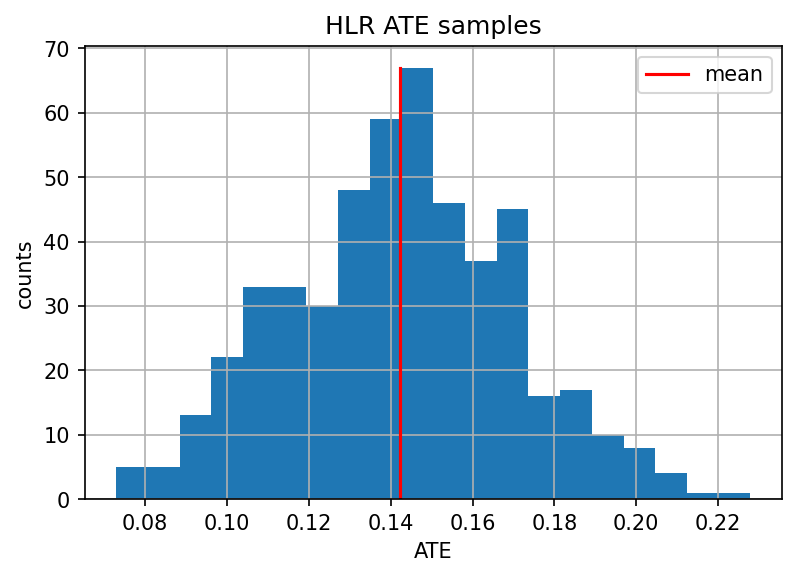

In [16]:
plt.figure(dpi=150)
cnt, *_ = plt.hist(ate_hlr_samples, bins=20)
plt.plot([ate_hlr, ate_hlr], [0, max(cnt)], 'r', label="mean")
plt.title("HLR ATE samples")
plt.xlabel("ATE")
plt.ylabel("counts")
plt.grid()
plt.legend()
plt.show()

## Plot ATE

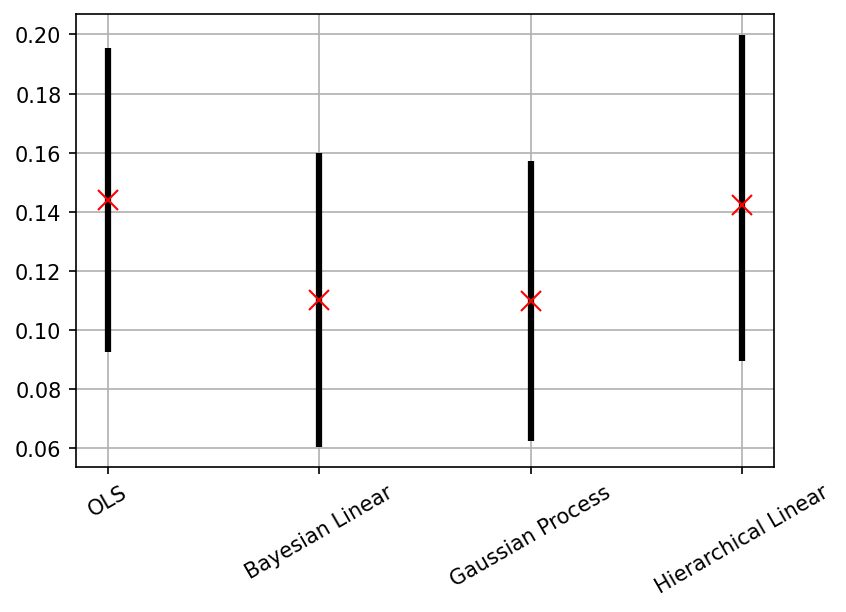

In [17]:
ate_labels = ["OLS", "Bayesian Linear", "Gaussian Process", "Hierarchical Linear"]
ate = [ate_ols, ate_blr, ate_gp, ate_hlr]
ci = [ci_ols, ci_blr, ci_gp, ci_hlr]
ind = np.arange(len(ate))

plt.figure(dpi=150)
plt.vlines(ind, ymin=[c[0] for c in ci], ymax=[c[1] for c in ci], colors='k', linewidth=3)
plt.plot(ind, ate, 'rx', markersize=10)
plt.xticks(ind, labels=ate_labels, rotation=30)
plt.grid()
plt.show()